In [1]:
import numpy as np
import pylab as plt
from PIL import Image
import matplotlib.pyplot as PLT
import json
import pandas as pd
import os
from lxml import etree

import chainer
import chainer.functions as F
import chainer.links as L

from chainer import datasets

In [2]:
#get images file list
file_list = []
for root, dirs, files in os.walk('./images/'):
    for file in files:
            file_list.append(file)

/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


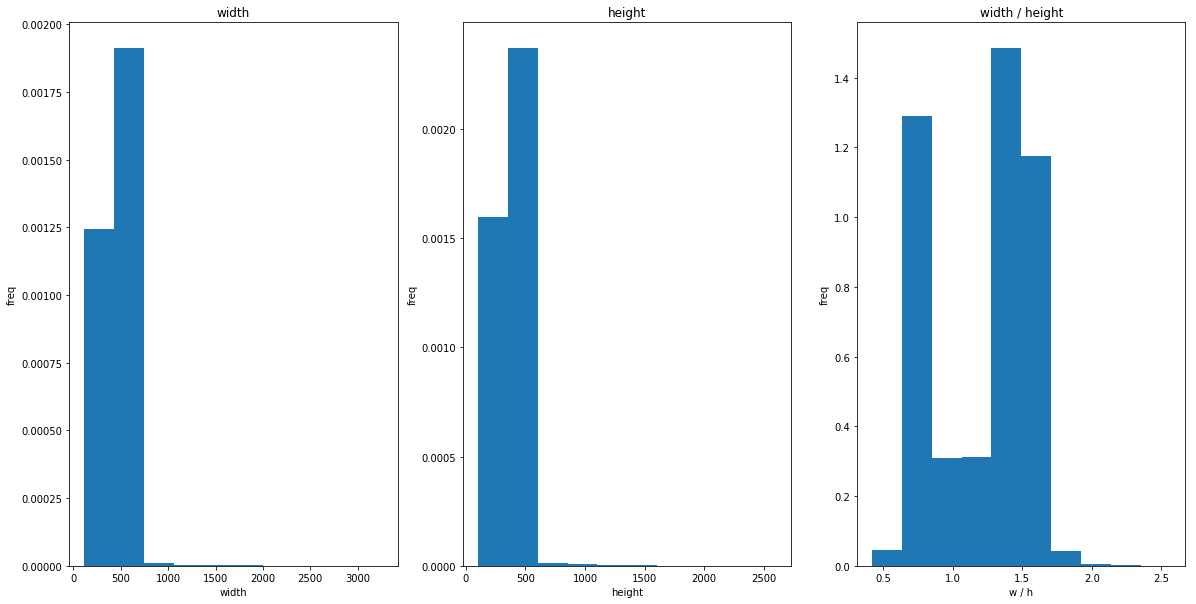

In [3]:
# analysis pic
w_list, h_list, rate_list = [], [], []
for file_name in file_list[:-3]:
    if os.path.splitext(file_name)[1] == '.jpg':
        img = Image.open('./images/%s'%(file_name))
        w, h = img.size
        w_list.append(w)
        h_list.append(h)
        rate_list.append(w / h)


PLT.figure(figsize=(20, 10))
# width
PLT.subplot(1, 3, 1)
PLT.hist(w_list, bins=10, normed=True)
PLT.title('width')
PLT.xlabel('width')
PLT.ylabel('freq')

# height
PLT.subplot(1, 3, 2)
PLT.hist(h_list, bins=10, normed=True)
PLT.title('height')
PLT.xlabel('height')
PLT.ylabel('freq')

# rate
PLT.subplot(1, 3, 3)
PLT.hist(rate_list, bins=10, normed=True)
PLT.title('width / height')
PLT.xlabel('w / h')
PLT.ylabel('freq')
PLT.show()

In [4]:
#get cut_images_size into a file list
Csize_file_list = []
for root, dirs, files in os.walk('./annotations/xmls/'):
    for file in files:
        if 'check' in os.path.splitext(file)[0]:
            print('check_img found')
        else:
            Csize_file_list.append(file)
 
C_all_data=[]
C_index = []
for i in Csize_file_list:
    C_one_data = []
    xml = etree.parse('./annotations/xmls/%s'%(i))
    xmin = xml.xpath('//bndbox/xmin/text()')
    ymin = xml.xpath('//bndbox/ymin/text()')
    xmax = xml.xpath('//bndbox/xmax/text()')
    ymax = xml.xpath('//bndbox/ymax/text()')
    index = xml.xpath('//filename/text()')
    C_one_data.append(int(str(xmin[0])))
    C_one_data.append(int(str(ymin[0])))
    C_one_data.append(int(str(xmax[0])))
    C_one_data.append(int(str(xmax[0])))
    C_all_data.append(C_one_data)
    C_index.append(str(index[0]))
C_df = pd.DataFrame(C_all_data,columns=['xmin','ymin','xmax','ymax'],index = C_index)

check_img found
check_img found


In [5]:
def load_image(img_path,augmentation=False, size=(224, 224)):    
    i = img_path
    if i in C_df.index:
                img = Image.open('./images/%s'%i)
                img_xml = img
                img_xml = img.crop((C_df.loc['%s'%i][0],C_df.loc['%s'%i][1],C_df.loc['%s'%i][2],C_df.loc['%s'%i][3]))
                img_xml = img_xml.resize((size),Image.ANTIALIAS)

                # 短辺長を基準とした正方形の座標を得る
                x_center = img_xml.size[0] // 2
                y_center = img_xml.size[1] // 2
                half_short_side = min(x_center, y_center)
                x0 = x_center - half_short_side
                y0 = y_center - half_short_side
                x1 = x_center + half_short_side
                y1 = y_center + half_short_side
    
                # Augmentation
                if augmentation:
                    # rotation
                    if np.random.random() > 0.5:
                        angle = np.random.uniform(-10, 10)
                        img = img_xml.rotate(angle, resample=Image.BILINEAR)
                    # flip
                    if np.random.random() > 0.5:
                        img = img_xml.transpose(Image.FLIP_LEFT_RIGHT)
                    # shift and scaling
                    if np.random.random() > 0.5:
                        range_x = img_xml.size[0] // 10
                        range_y = img_xml.size[1] // 10
                        x0 = max(0, np.random.randint(x0 - range_x, x0 + range_x))
                        y0 = max(0, np.random.randint(y0 - range_y, y0 + range_y))
                        x1 = min(img.size[0], np.random.randint(x1 - range_x, x1 + range_x))
                        y1 = min(img.size[1], np.random.randint(y1 - range_y, y1 + range_y))
                        
                img = img_xml.resize((size),Image.ANTIALIAS)
                img = np.array(img_xml, dtype=np.float32)
                if img.shape[0] > 224:
                    img = img[:224,]
                if img.shape[1] >224:
                    img = img[:,:224]
                return img

    else:
                img = Image.open('./images/%s'%i)
                img = img.resize((size),Image.ANTIALIAS)
                # 短辺長を基準とした正方形の座標を得る
                x_center = img.size[0] // 2
                y_center = img.size[1] // 2
                half_short_side = min(x_center, y_center)
                x0 = x_center - half_short_side
                y0 = y_center - half_short_side
                x1 = x_center + half_short_side
                y1 = y_center + half_short_side
                # Augmentation
                if augmentation:
                    # rotation
                    if np.random.random() > 0.5:
                        angle = np.random.uniform(-10, 10)
                        img = img.rotate(angle, resample=Image.BILINEAR)
                    # flip
                    if np.random.random() > 0.5:
                        img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    # shift and scaling
                    if np.random.random() > 0.5:
                        range_x = img.size[0] // 10
                        range_y = img.size[1] // 10
                        x0 = max(0, np.random.randint(x0 - range_x, x0 + range_x))
                        y0 = max(0, np.random.randint(y0 - range_y, y0 + range_y))
                        x1 = min(img.size[0], np.random.randint(x1 - range_x, x1 + range_x))
                        y1 = min(img.size[1], np.random.randint(y1 - range_y, y1 + range_y))
                img = img.resize((size),Image.ANTIALIAS)
                img = np.array(img, dtype=np.float32)
                if img.shape[0] > 224:
                    img = img[:224,]
                if img.shape[1] >224:
                    img = img[:,:224]
                return img

vgg16 model

In [6]:
#building chainer & intial VGG16 model
import numpy as np
import chainer
from chainer import datasets, iterators, optimizers, serializers
from chainer import Function
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [7]:
vgg = L.VGG16Layers()

ファインチューニング用モデルの作成

In [8]:
# VGG16のレイヤ
vgg._children

{'conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'fc6',
 'fc7',
 'fc8'}

In [9]:
class Model(chainer.Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.vgg = L.VGG16Layers()
            self.fc = L.Linear(None, 17)

    def __call__(self, x, train=False):
        with chainer.using_config('train', train):
            h = self.vgg(x, layers=['fc7'])['fc7']
            y = self.fc(h)
        return y

In [10]:
model = Model()

In [11]:
#learning begin

##batch making
def make_batch(data_list, augmentation=True):
    x_batch = []
    t_batch = []
    for img_path, label in data_list:
        img = load_image(img_path, augmentation=augmentation)
        img = img.transpose(2, 0, 1)
        if img.shape[0] == 4:
            img = img[:3]
        img = img[::-1]
        img -= np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(3, 1, 1)

        x_batch.append(img)
        t_batch.append(label)
        
    return np.array(x_batch, dtype=np.float32), np.array(t_batch, dtype=np.int32)


In [6]:
# データの分割
all_list = []
label_list = []
test_data = []
train_data =[]

#locate train images and label on json
train_label = []
train_data_name = []
train_list_slice_c = []
train_list_slice_d = []

data_str = open('./train.json').read()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
df = pd.read_json(data_str)
for j in range(12):
    train_list_slice_c= train_list_slice_c+(df.iloc[:12,0].iloc[j]['images'])
    for count_c in df.iloc[:12,0].iloc[j]['images']:
        train_data.append((count_c+'.jpg',1))
      
for i in range(23):
    train_list_slice_d= train_list_slice_d+(df.iloc[12:,1].iloc[i]['images'])
    for count_d in df.iloc[12:,1].iloc[i]['images']:
        train_data.append((count_d+'.jpg',2))

train_data_name =train_list_slice_c+train_list_slice_d


#locate test images and label on json
test_label =[]
test_data_name = []
test_list_slice_c = []
test_list_slice_d = []

data_str = open('./test.json').read()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
df = pd.read_json(data_str)
test_label = []
test_list_slice = []
for j in range(12):
    test_list_slice_c= test_list_slice_c+(df.iloc[:12,0].iloc[j]['images'])
    for count_c in df.iloc[:12,0].iloc[j]['images']:
        test_data.append((count_c+'.jpg',1))
for i in range(23):
    test_list_slice_d= test_list_slice_d+(df.iloc[12:,1].iloc[i]['images'])
    for count_d in df.iloc[12:,1].iloc[i]['images']:
        test_data.append((count_d+'.jpg',2))
    
test_data_name = test_list_slice_c+test_list_slice_d
    
    
all_list = test_data_name+train_data_name 

all_list = [jpg+'.jpg' for jpg in all_list]

print(len(train_data))
print(len(test_data))
print(len(train_data_name))
#print(test_data_name)

1967
5382
1967


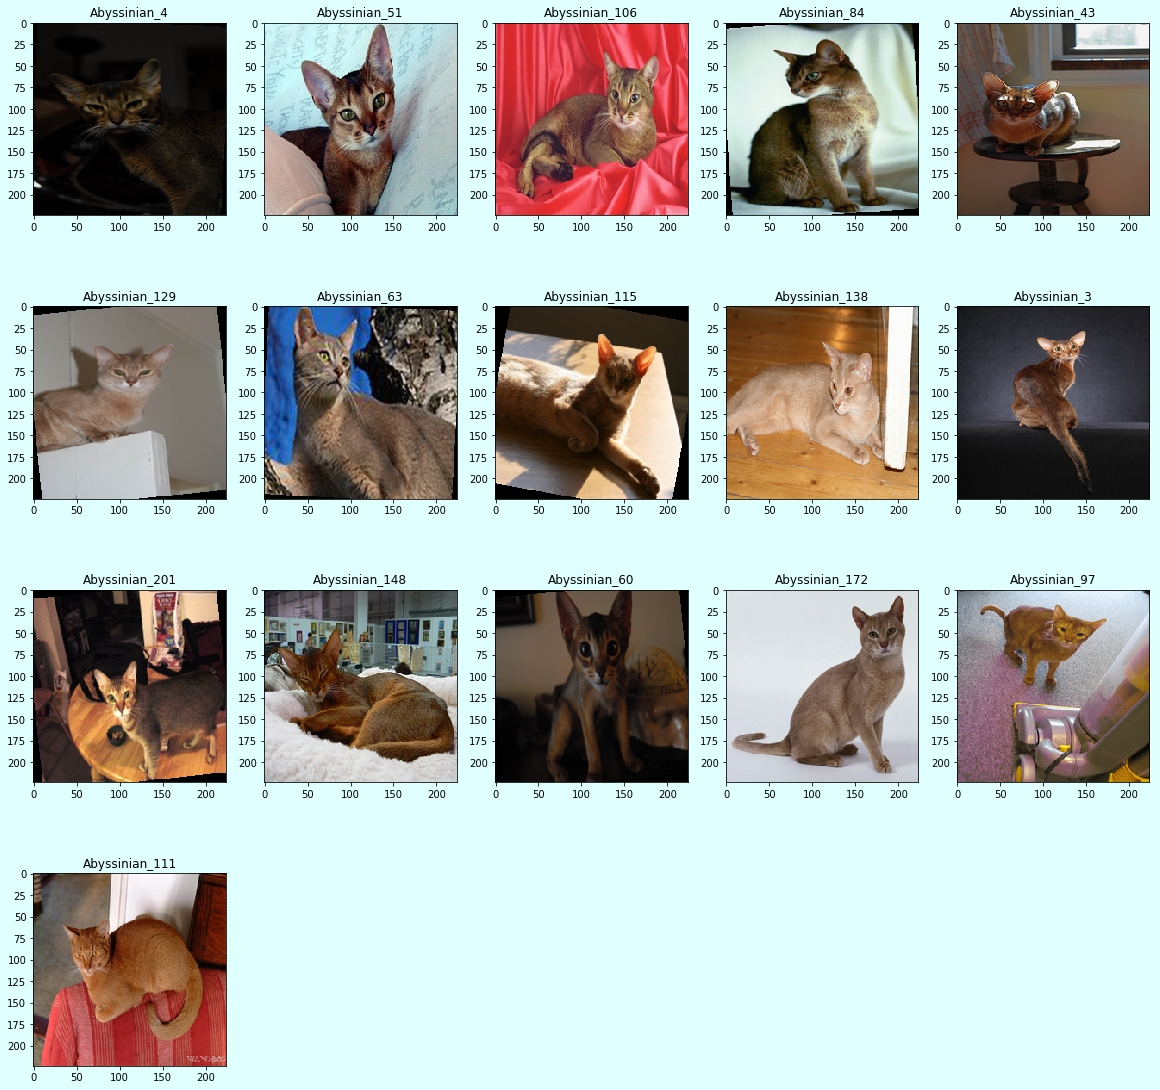

In [145]:
#read 17 train pics according to the json file
pic = PLT.figure(figsize=(20, 20))
pic.patch.set_facecolor('lightcyan')
j = 0
for i in train_data_name:
    j = j+1
    if j <17:
        img = './%s'%(i+'.jpg')
        img_train = load_image(img,augmentation=True)
        PLT.subplot(4,5,j)
        PLT.title(i)
        PLT.imshow(img_train/255)
    else:
        break


In [15]:
train_data = np.array(train_data)
test_data = np.array(test_data)
print(train_data[[3, 5, 199]]) # 3,5, 6番目を取り出す
train_data_l=[]
for i in range(len(train_data)):
    train_data_l.append(train_data[i][0])

[['Abyssinian_84.jpg' '1']
 ['Abyssinian_129.jpg' '1']
 ['Bengal_153.jpg' '1']]


##learning loop

In [16]:
# 設定
n_epoch = 10
batch_size = 16

model = Model()

In [17]:
opt = optimizers.MomentumSGD(lr=1e-4)
opt.setup(model)

In [18]:
model.fc.W.update_rule.hyperparam.lr = 1e-3
model.fc.b.update_rule.hyperparam.lr = 1e-3

In [19]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [20]:
perm = np.random.permutation(1967)
print(len(perm))
train_data[perm[1190:1200]]
print(n_epoch)

1967
10


In [26]:
import numpy as np
import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer.training import extensions

for epoch in range(n_epoch):
    print('epoch: {}'.format(epoch))
    
    # 学習
    print('train')
    perm = np.random.permutation(len(train_data))
    sum_loss = 0.
    sum_acc = 0.
    
    model.to_gpu()
    
    for i in range(0, len(perm), batch_size):
#        print(train_data[perm[i:i+batch_size]])
        print(i)
        # prepare minibatch
        x_batch, t_batch = make_batch(train_data[perm[i:i+batch_size]], augmentation=True)
        x_batch = model.xp.array(x_batch) # model.xpはmodelがGPUにあるときはcupy, CPUにあるときはnumpyになる。
        t_batch = model.xp.array(t_batch)

        # forward
        y = model(x_batch, train=True)
        loss = F.softmax_cross_entropy(y, t_batch)
        acc = F.accuracy(y, t_batch)
        
        # backward and update
        model.cleargrads()
        loss.backward()
        opt.update()

        # lossとaccuracyの記録
        # これらはバッチサイズで割られた値なので評価時と正しく比較するためにミニバッチのデータ数をかけて補正しておく
        sum_loss += cuda.to_cpu(loss.data) * len(x_batch)
        sum_acc += cuda.to_cpu(acc.data) * len(x_batch)

    train_loss.append(sum_loss / len(train_data)) # 全データ数で割る
    train_acc.append(sum_acc / len(train_data))

    # このepochのloss, accuracyの和を表示
    print(train_loss[-1], train_acc[-1])

    # 評価
    print('test')
    sum_loss = 0.
    sum_acc = 0.
    for i in range(0, len(test_data), batch_size):
        x_batch, t_batch = make_batch(test_data[i:i+batch_size], augmentation=False)
        x_batch = model.xp.array(x_batch)
        t_batch = model.xp.array(t_batch)
        b = x_batch.shape[0]
        
        # forward
        y = model(x_batch, train=False)
        loss = F.softmax_cross_entropy(y, t_batch)
        acc = F.accuracy(y, t_batch)

        # lossとaccuracyの記録
        sum_loss += cuda.to_cpu(loss.data) * len(x_batch)
        sum_acc += cuda.to_cpu(acc.data) * len(x_batch)

    test_loss.append(sum_loss / len(test_data))
    test_acc.append(sum_acc / len(test_data))

    # このepochのloss, accuracyの和を表示
    print(test_loss[-1], test_acc[-1])

epoch: 0
train
0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240
256
272
288
304
320
336
352
368
384
400
416
432
448
464
480
496
512
528
544
560
576
592
608
624
640
656
672
688
704
720
736
752
768
784
800
816
832
848
864
880
896
912
928
944
960
976
992
1008
1024
1040
1056
1072
1088
1104
1120
1136
1152
1168
1184
1200
1216
1232
1248
1264
1280
1296
1312
1328
1344
1360
1376
1392
1408
1424
1440
1456
1472
1488
1504
1520
1536
1552
1568
1584
1600
1616
1632
1648
1664
1680
1696
1712
1728
1744
1760
1776
1792
1808
1824
1840
1856
1872
1888
1904
1920
1936
1952
0.007227527471018227 0.9984748347737672
test
0.4933464643637162 0.8652917131178001
epoch: 1
train
0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240
256
272
288
304
320
336
352
368
384
400
416
432
448
464
480
496
512
528
544
560
576
592
608
624
640
656
672
688
704
720
736
752
768
784
800
816
832
848
864
880
896
912
928
944
960
976
992
1008
1024
1040
1056
1072
1088
1104
1120
1136
1152
1168
1184
1200
1216
1232
1248
1264
1280
1296
1312

[0.9933909506863243, 0.9984748347737672, 0.9994916115912558, 1.0, 1.0, 1.0, 0.9994916115912558, 0.9994916115912558, 1.0, 1.0, 1.0]
[0.8652917131178001, 0.9288368636194723, 0.9230769230769231, 0.9405425492382015, 0.9080267558528428, 0.9119286510590858, 0.9057971014492754, 0.9149015235971758, 0.9171311780007432, 0.9130434782608695]


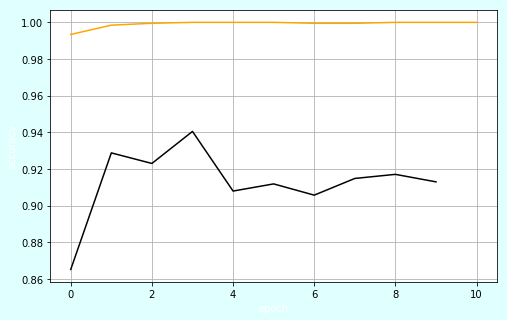

In [146]:
import matplotlib.pyplot as plt
# Accuracy
print(train_acc)
print(test_acc)
pic = plt.figure(figsize=(8, 5))
pic.patch.set_facecolor('lightcyan')
plt.grid(True)
plt.xlabel('epoch',color ='white')
plt.ylabel('accuracy',color ='white')
plt.plot(train_acc,color = 'orange')
plt.plot(test_acc,color = 'black')
plt.show()

[0.023030443608517706, 0.007227527471018227, 0.002476161303996271, 0.0015721340501507206, 0.0008229869964819183, 0.00045138903555055925, 0.0008002112950758827, 0.0009050260231194305, 0.00022785640575257766, 0.00031330116408847245, 0.00011257478047823263]
[0.4933464643637162, 0.27864098021866485, 0.31190745558815347, 0.25322710355970107, 0.38581832254389237, 0.3840642438385399, 0.4183295052685467, 0.3844441765554551, 0.38090418794703546, 0.40093957230764354]


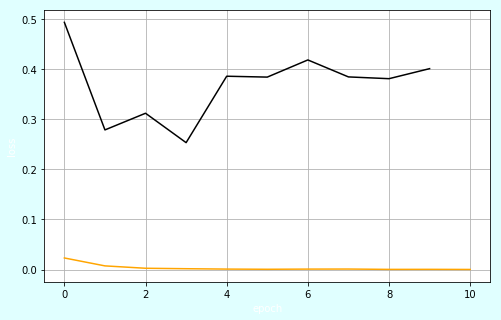

In [147]:
# Loss
print(train_loss)
print(test_loss)
pic = plt.figure(figsize=(8, 5))
pic.patch.set_facecolor('lightcyan')
plt.grid(True)
plt.xlabel('epoch',color ='white')
plt.ylabel('loss',color = 'white')
plt.plot(train_loss,color = 'orange')
plt.plot(test_loss,color = 'black')
plt.show()

In [126]:
import numpy as np
import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer.training import extensions

# すべてのテストデータに対する予測と正解ラベルを並べた行列をつくる
ys = [] # 予測
ts = [] # 正解ラベル
model.to_gpu()
for i in range(0, len(test_data), batch_size):
    x_batch, t_batch = make_batch(test_data[i:i+batch_size], augmentation=False)
    x_batch = model.xp.array(x_batch)
    t_batch = model.xp.array(t_batch)
    y = model(x_batch, train=False)
    y = F.softmax(y)
    ys.append(cuda.to_cpu(y.data))
    ts.append(cuda.to_cpu(t_batch))
ys = np.concatenate(ys)
ts = np.concatenate(ts)
pred = np.argmax(ys, axis=1)

In [127]:
# confusion matrixを表示するための関数
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize='large',color ='white')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,color ='white')
    plt.yticks(tick_marks, classes,color ='white')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',color ='white')
    plt.xlabel('Predicted label',color ='white')

In [128]:
confmat = metrics.confusion_matrix(ts, pred)
classes = ['cat','dog']

Normalized confusion matrix
[[1.         0.        ]
 [0.09537396 0.90462604]]

 accuracy: 
 0.9130434782608695

 precision: 
 0.503711558854719

 recall: 
 1.0


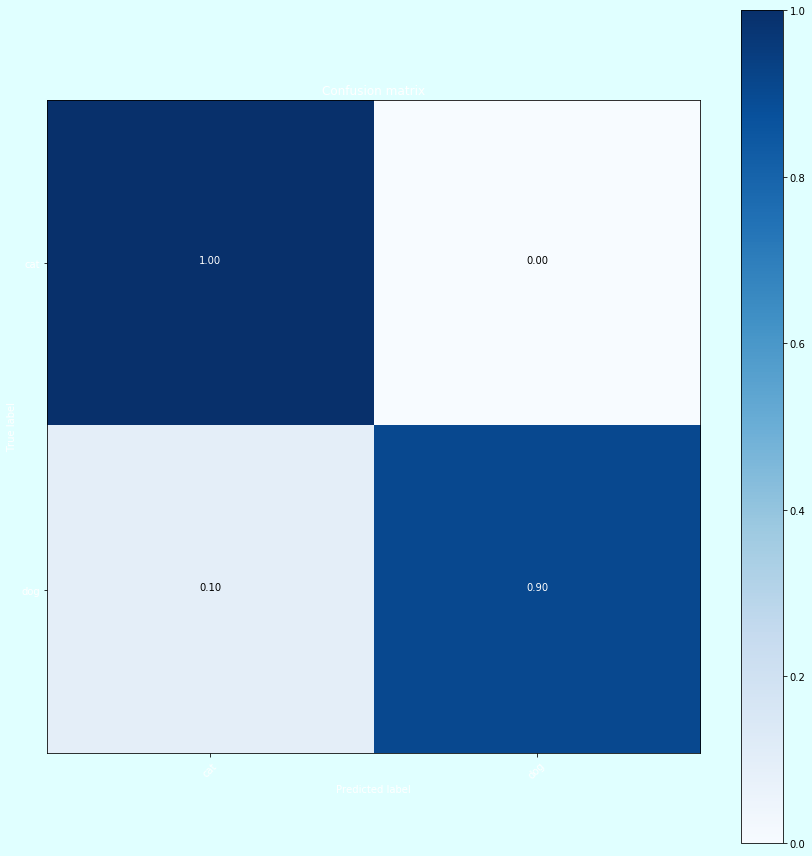

In [148]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
pic = plt.figure(figsize=(12, 12))
pic.patch.set_facecolor('lightcyan')
plot_confusion_matrix(confmat, classes=classes, normalize=True)
print('\n','max_accuracy:','\n',accuracy_score(ts, pred))
print('\n','max_precision:','\n',precision_score(ts, pred))
print('\n','max_recall:','\n',recall_score(ts, pred))

In [155]:
from sklearn.manifold import TSNE
Y_embedded = TSNE(n_components=2).fit_transform(ys)

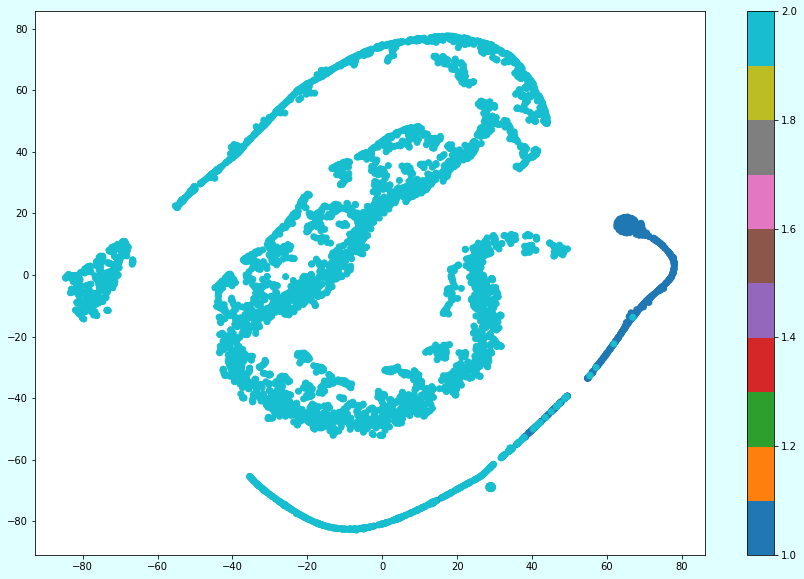

In [159]:
pic = plt.figure(figsize=(15, 10))
pic.patch.set_facecolor('lightcyan')
plt.scatter(Y_embedded[:, 0], Y_embedded[:,1], c=ts, cmap='tab10')
plt.colorbar()

In [160]:
# save
chainer.serializers.save_npz('./Vgg16_pet.model', model)

In [ ]:
# load
chainer.serializers.load_npz('./finetune.model', model)

In [764]:
import numpy as np
import chainer
from chainer import datasets, iterators, optimizers, serializers
from chainer import Function
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [765]:
#model initialization
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        net = [('conv1', L.Convolution2D(1, 6, 5, 1))]
        net += [('_sigm1', F.sigmoid())]
        net += [('_mpool1', F.MaxPooling2D(2, 2))]
        net += [('conv2', L.Convolution2D(6, 16, 5, 1))]
        net += [('_sigm2', F.sigmoid())]
        net += [('_mpool2', F.MaxPooling2D(2, 2))]
        net += [('conv3', L.Convolution2D(16, 120, 4, 1))]
        net += [('_sigm3', F.sigmoid())]
        net += [('_mpool3', F.MaxPooling2D(2, 2))]
        net += [('fc4', L.Linear(None, 84))]
        net += [('_sigm4', F.sigmoid())]
        net += [('fc5', L.Linear(84, 10))]
        net += [('_sigm5', F.sigmoid())]
        with self.init_scope():
            for n in net:
                if not n[0].startswith('_'):
                    setattr(self, n[0], n[1])
        self.forward = net
        

    def __call__(self, x):
        for n, f in self.forward:
            if not n.startswith('_'):
                x = getattr(self, n)(x)
            else:
                x = f(x)
        if chainer.config.train:
            return x
        return F.softmax(x)
    
model=LeNet5()
y = model(input_data)

TypeError: sigmoid() missing 1 required positional argument: 'x'

In [340]:
#model = LeNet5()
#y = model(input_data)
print(input_data)
x = np.random.rand(32, 1, 28, 28).astype(np.float32)
print(x)
# Loss calculation
#loss = F.softmax_cross_entropy(y, train_label_n)
# Input data and label
#print(input_data)

'''

t = np.random.randint(0, 10, size=(32,)).astype(np.int32

# Forward computation
y = model(x)

# Loss calculation
loss = F.softmax_cross_entropy(y, t)
'''

[[[[106.  55. 114. ... 214. 185. 200.]
   [ 48.   5.  38. ...  71.  49.  76.]
   [ 24.   0.  12. ...  65.  49.  74.]
   ...
   [249. 251. 250. ...  80. 103. 100.]
   [253. 252. 253. ... 187. 184. 183.]
   [247. 246. 247. ...  95.  79.  87.]]]


 [[[251. 250. 251. ...  96.  76.  88.]
   [253. 251. 253. ... 190. 181. 193.]
   [247. 245. 247. ... 112.  76. 108.]
   ...
   [ 99. 102. 105. ...  38.  50.  75.]
   [ 62.  68.  75. ...  39.  53.  74.]
   [123. 124. 128. ... 187. 181. 196.]]]


 [[[ 94.  94.  98. ...  89.  97. 109.]
   [ 64.  66.  70. ...  80.  87.  99.]
   [119. 121. 125. ... 184. 178. 180.]
   ...
   [ 70.  89. 118. ... 133. 127. 143.]
   [ 42.  64.  93. ... 117. 115. 132.]
   [ 20.  42.  73. ...  91.  91. 114.]]]]
[[[[0.799749   0.807992   0.8876011  ... 0.36311507 0.52367234
    0.42681357]
   [0.69997376 0.46772873 0.82081485 ... 0.8691128  0.83981496
    0.4058793 ]
   [0.63158953 0.78941214 0.4107194  ... 0.8832563  0.05572477
    0.8957595 ]
   ...
   [0.03839029 0.54651

'\n\nt = np.random.randint(0, 10, size=(32,)).astype(np.int32\n\n# Forward computation\ny = model(x)\n\n# Loss calculation\nloss = F.softmax_cross_entropy(y, t)\n'